In [1]:
import DataLoader, Training, os, warnings
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import captum, torch, mne
from torch.utils.data import TensorDataset
from captum.attr import Saliency, DeepLift
from matplotlib import cm
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap

In [2]:
#plt.rcParams.update(plt.rcParamsDefault)
def plot_attribution(attribution, title=None):
    plt.figure(figsize=(15, 5))
    if title != None:
        plt.title(title)
    plt.xticks(np.arange(0, 251, step=25),np.round(np.arange(-0.2, 0.81, step=0.1),2))
    plt.yticks(np.arange(0, 28, step=1),
           ['F3','F7','FC3','C3','C5','P3','P7','P9','PO7','PO3','O1','Oz','Pz','CPz','Fz','F4','F8','FC4','FCz','Cz','C4','C6','P4','P8','P10','PO8','PO4','O2'])
    plt.imshow(attribution[0,:,:].detach().numpy(),aspect="auto",cmap="viridis")

In [ ]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"
task = "N170"
model_name = "deep"
model_folder = "ModelComparison"

df = DataLoader.load_df(data_path, task, preprocessing)
clf, model = Training.init_model(model_name, lr=0.01, gpu=False)
model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
clf.load_params(f_params=model_path+"split_"+str(1)+"_model.pkl",
                       f_optimizer=model_path+"split_"+str(1)+"_optimizer.pkl",
                       f_history=model_path+"split_"+str(1)+"_history.json")
## abs. deeplift, 1000 random inputs
dl = DeepLift(model)
attribution = 0
for i in range(1000):
    tensor = torch.randn(1, 28, 251, requires_grad=True)
    attribution += abs(dl.attribute(tensor, target=0))
plot_attribution(attribution, task)

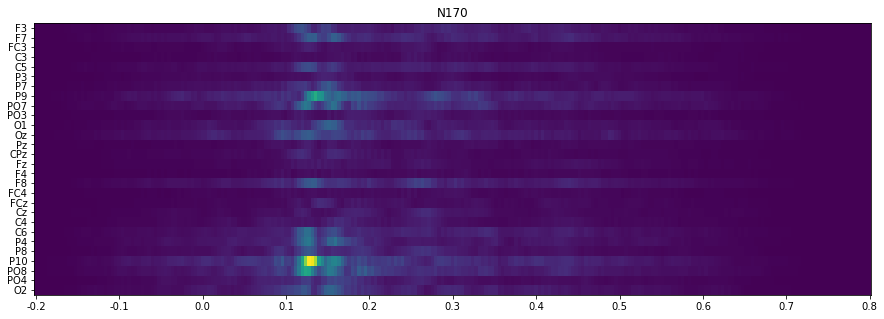

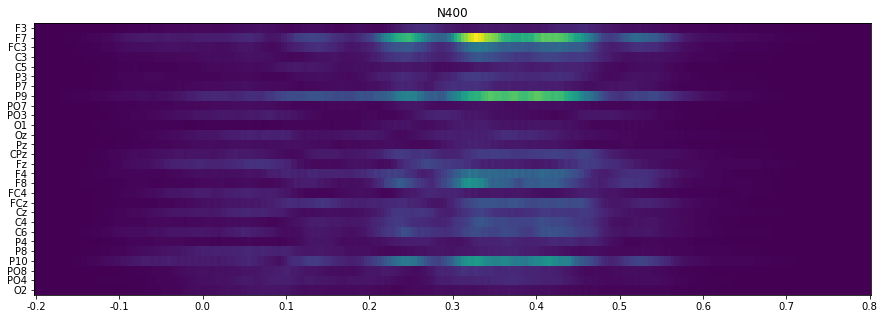

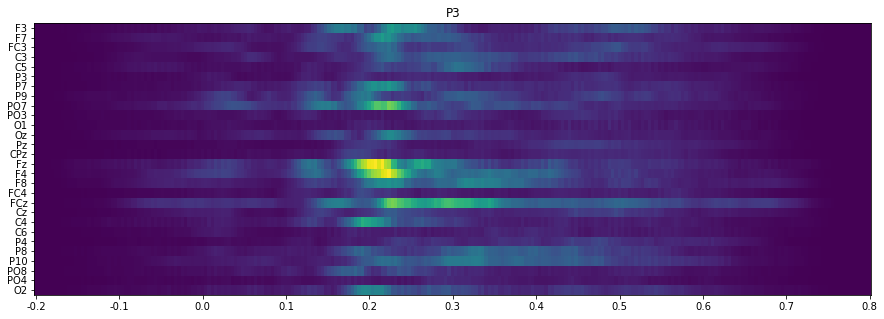

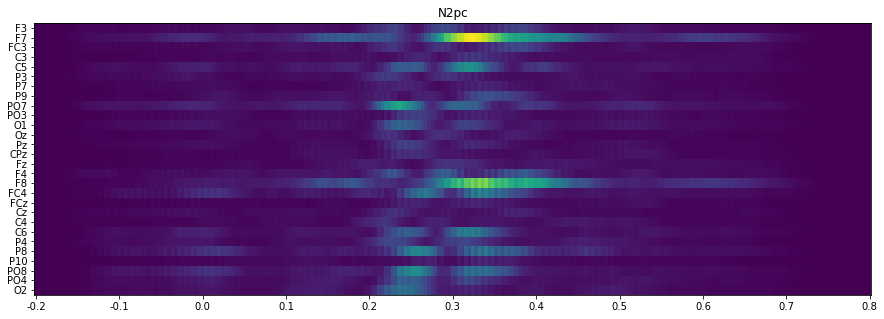

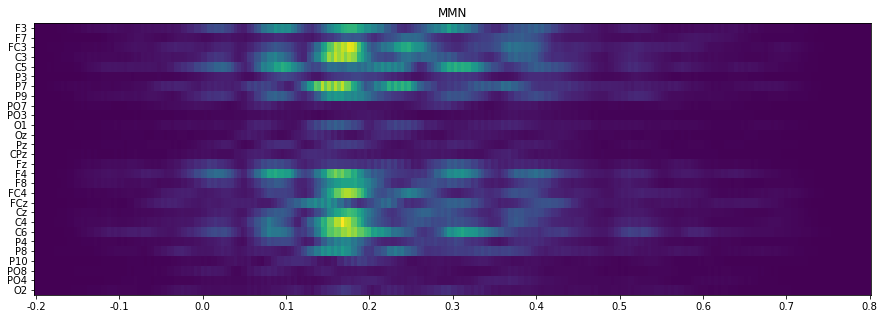

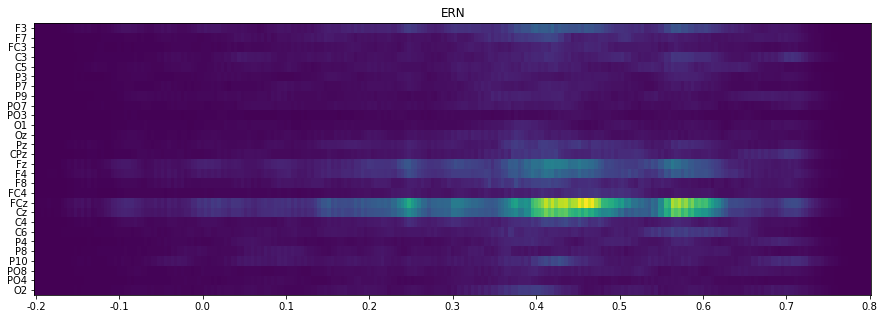

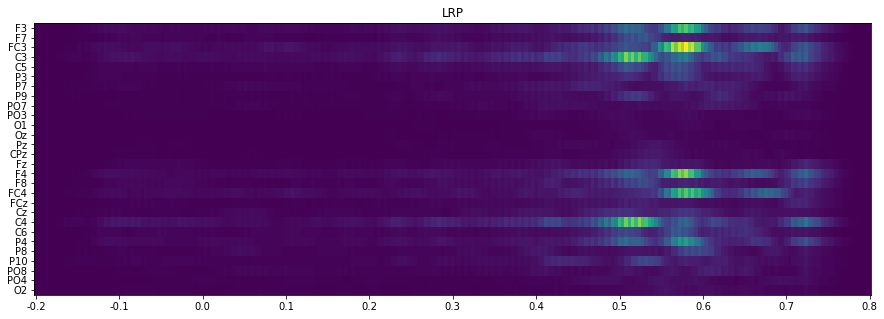

In [4]:
## abs deeplift, 100 random samples

data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"
model_name = "deep"
model_folder = "ModelComparison"

for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    df = df.sample(100)
    data, labels = DataLoader.create_data_labels(df)
    clf, model = Training.init_model(model_name, lr=0.01, gpu=False)
    model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
    clf.load_params(f_params=model_path+"split_"+str(1)+"_model.pkl",
                           f_optimizer=model_path+"split_"+str(1)+"_optimizer.pkl",
                           f_history=model_path+"split_"+str(1)+"_history.json") 
    dl = DeepLift(model)
    attribution = 0
    for i in range(len(data)):
        tensor = torch.from_numpy(data[i].reshape(1,28,251)).float()
        tensor.requires_grad = True
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            attribution += abs(dl.attribute(tensor, target=0))
    plot_attribution(attribution, task)

In [5]:
def plot_attribution_line(data, attribution, title=None):
    sns.set(style="darkgrid")
    
    x = np.linspace(-200, 1000, 251)
    y = data.mean(axis=0).mean(axis=0)
    t = attribution.detach().numpy().mean(axis=1).flatten()
    c = (t - np.min(t))/np.ptp(t)
    # adapted from https://matplotlib.org/3.1.1/gallery/
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    fig, axs = plt.subplots(1, 1, figsize=(15, 5), dpi=100)
    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(c.min(), c.max())
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(c)
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
    fig.colorbar(line, ax=axs)
    axs.set_xlim(x.min(), x.max())
    axs.set_ylim(y.min()*1.1, y.max()*1.1)
    if title != None:
        plt.title(title)

In [6]:
def plot_attribution_lines(data, attribution, data2, attribution2, title=None):
    sns.set(style="darkgrid")
    
    x = np.linspace(-200, 1000, 251)
    y = data.mean(axis=0).mean(axis=0)
    t = attribution.detach().numpy().mean(axis=1).flatten()
    c = (t - np.min(t))/np.ptp(t)
    y2 = data2.mean(axis=0).mean(axis=0)
    t2 = attribution2.detach().numpy().mean(axis=1).flatten()
    c2 = (t2 - np.min(t2))/np.ptp(t2)
    # adapted from https://matplotlib.org/3.1.1/gallery/
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    points2 = np.array([x, y2]).T.reshape(-1, 1, 2)
    segments2 = np.concatenate([points2[:-1], points2[1:]], axis=1) 
    
    fig, axs = plt.subplots(1, 1, figsize=(15, 5), dpi=100)
    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(c.min(), c.max())
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(c)
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
    
    norm2 = plt.Normalize(c2.min(), c2.max())
    lc2 = LineCollection(segments2, cmap='viridis', norm=norm2)
    # Set the values used for colormapping
    lc2.set_array(c2)
    lc2.set_linewidth(2)
    line2 = axs.add_collection(lc2)  
    
    fig.colorbar(line, ax=axs) 
    
    axs.set_xlim(x.min(), x.max())
    axs.set_ylim(min(y.min(),y2.min())*1.1, max(y.max(),y2.max())*1.1)
    if title != None:
        plt.title(title)

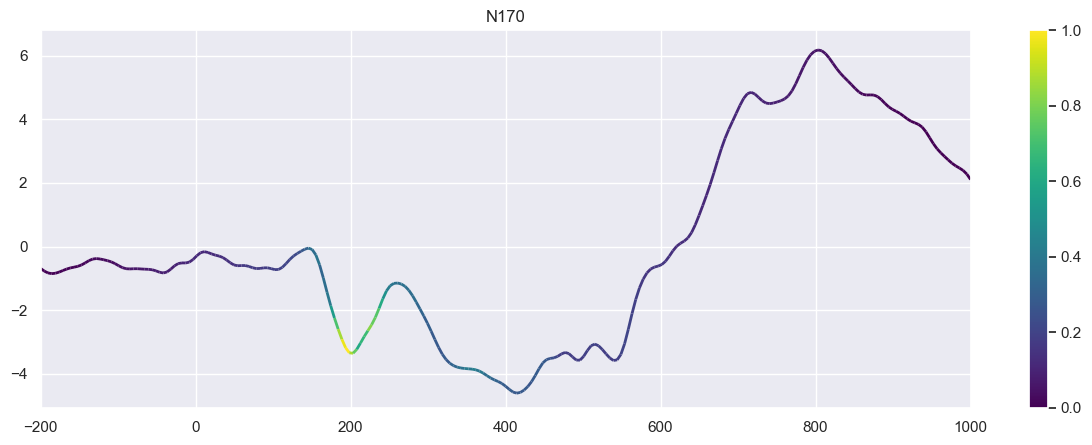

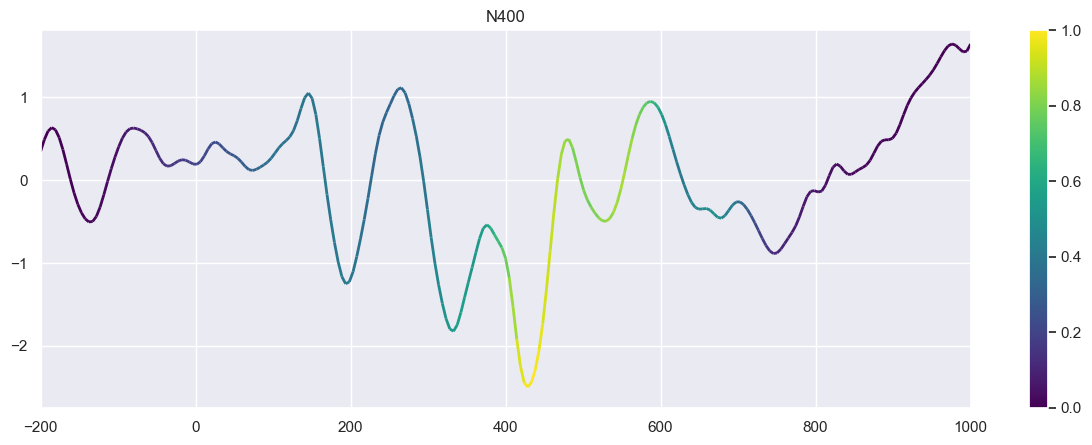

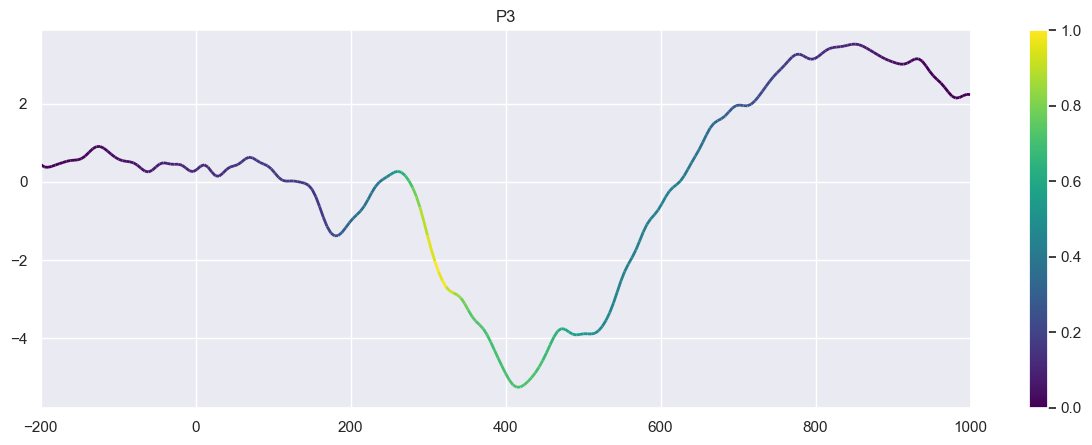

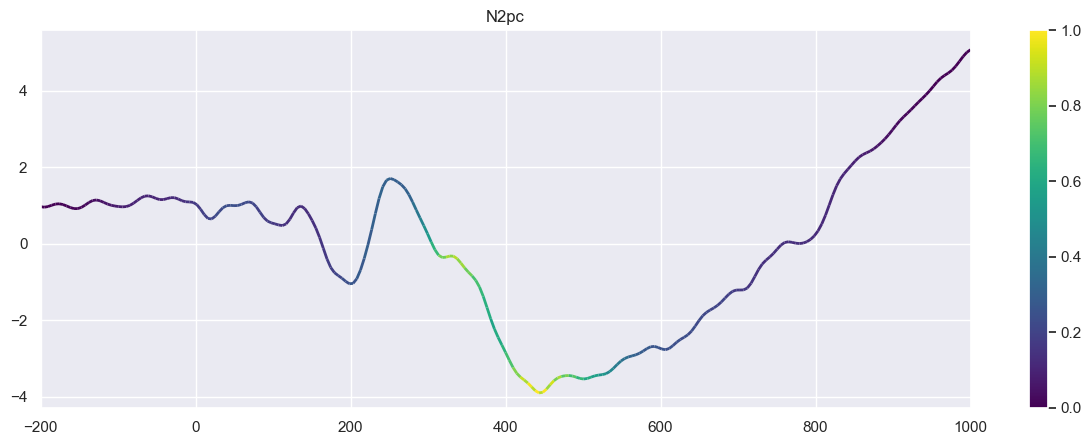

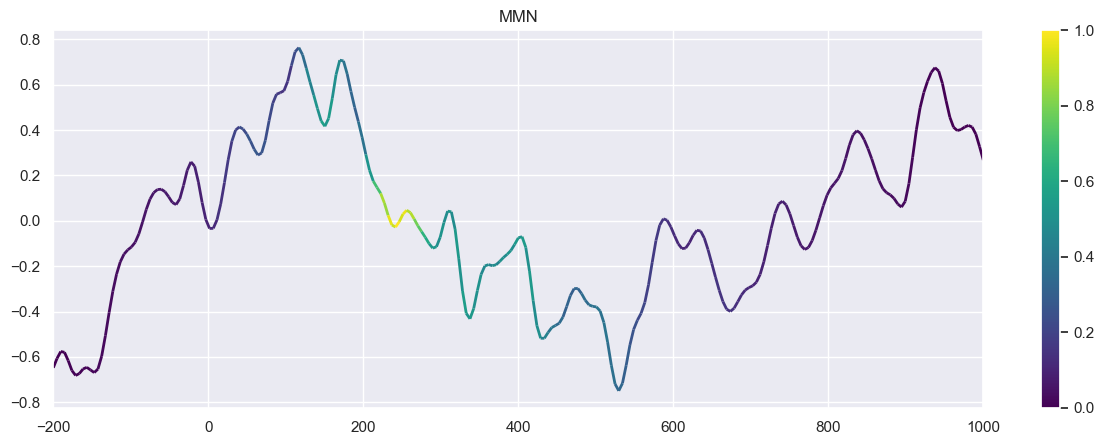

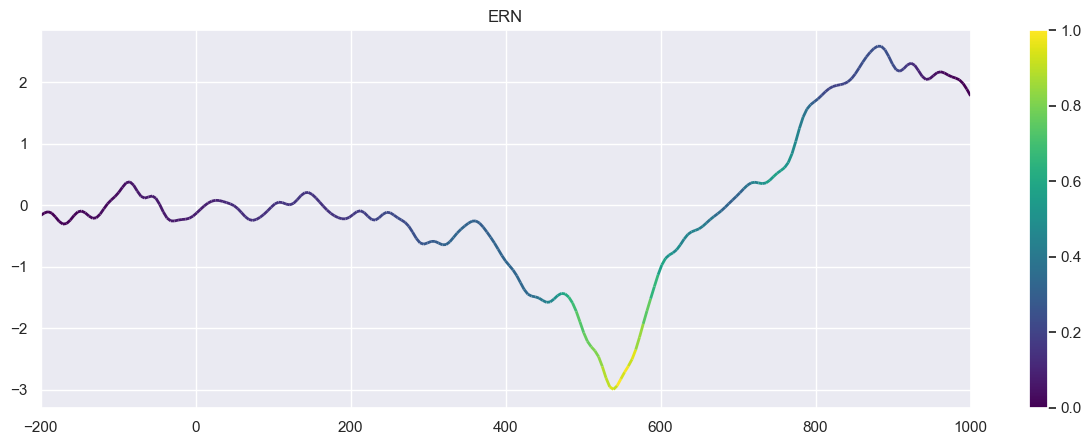

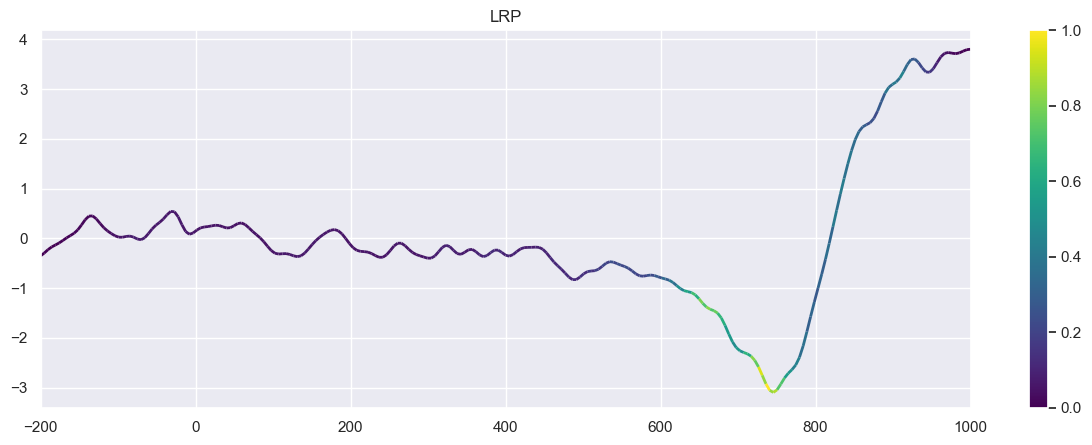

In [7]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"
model_name = "deep"
model_folder = "ModelComparison"

for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    df = df[df["condition"]==1].sample(1000)
    data, labels = DataLoader.create_data_labels(df)
    clf, model = Training.init_model(model_name, lr=0.01, gpu=False)
    model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
    clf.load_params(f_params=model_path+"split_"+str(1)+"_model.pkl",
                           f_optimizer=model_path+"split_"+str(1)+"_optimizer.pkl",
                           f_history=model_path+"split_"+str(1)+"_history.json")

    dl = DeepLift(model)
    attribution = 0
    for i in range(len(data)):
        tensor = torch.from_numpy(data[i].reshape(1,28,251)).float()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            attribution += abs(dl.attribute(tensor, target=0))
    plot_attribution_line(data, attribution, task)

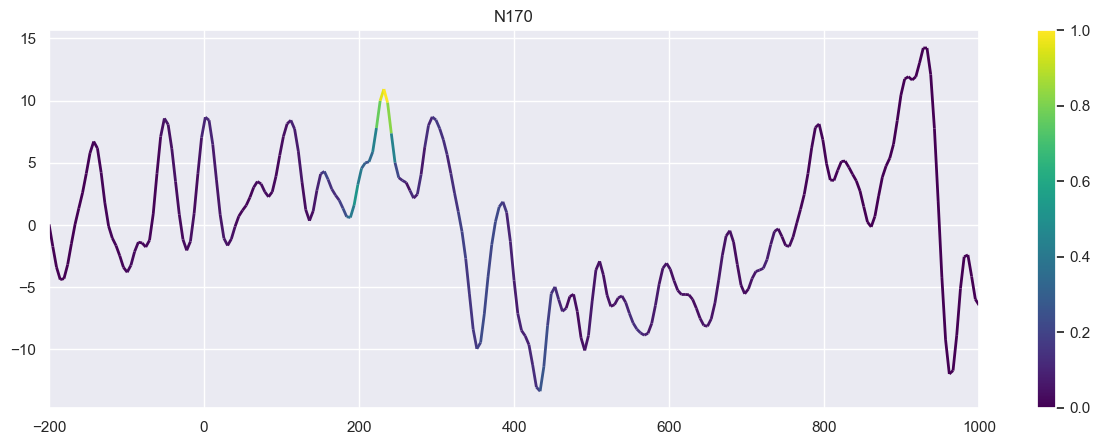

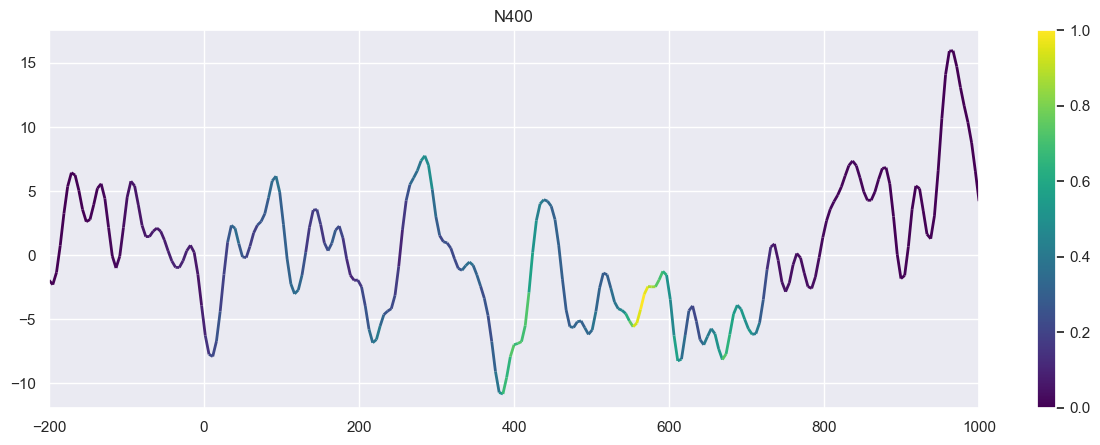

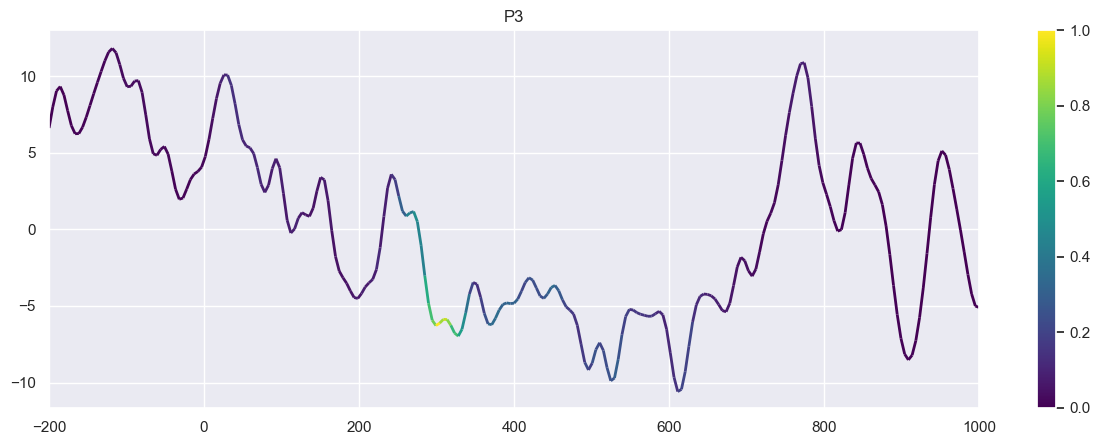

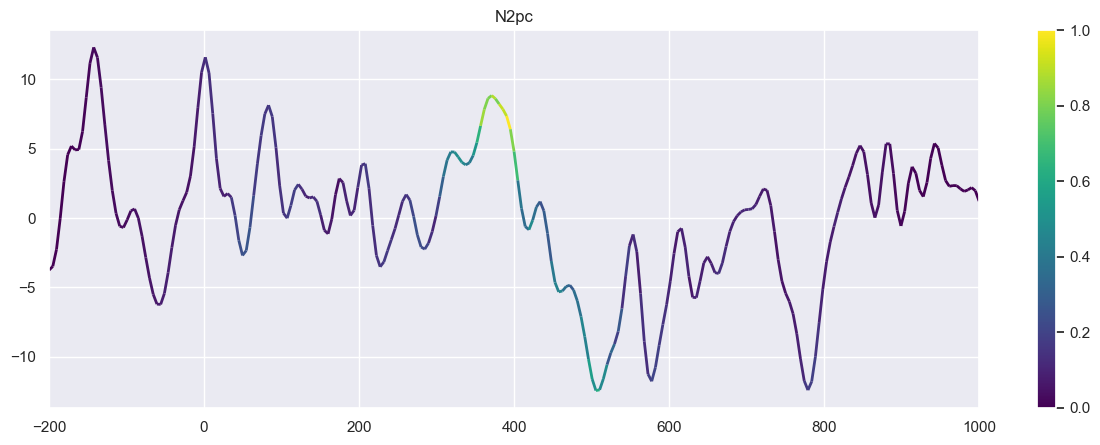

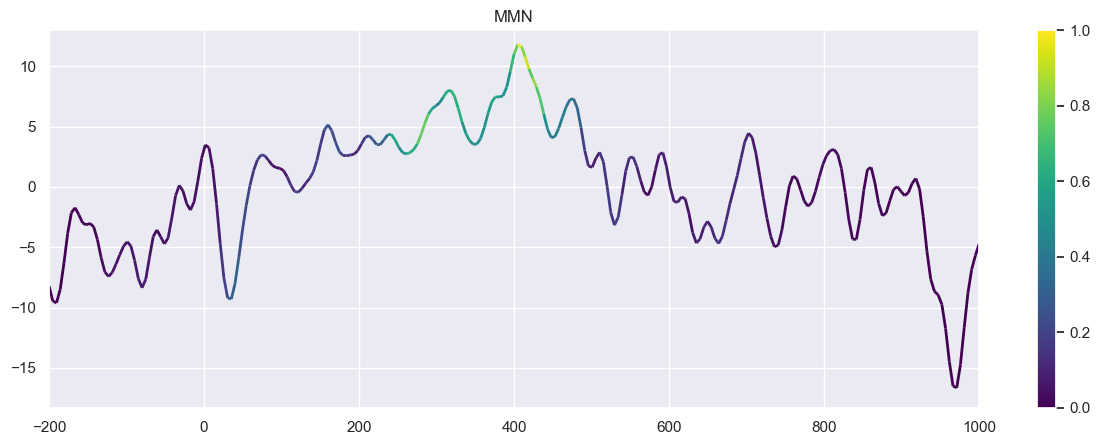

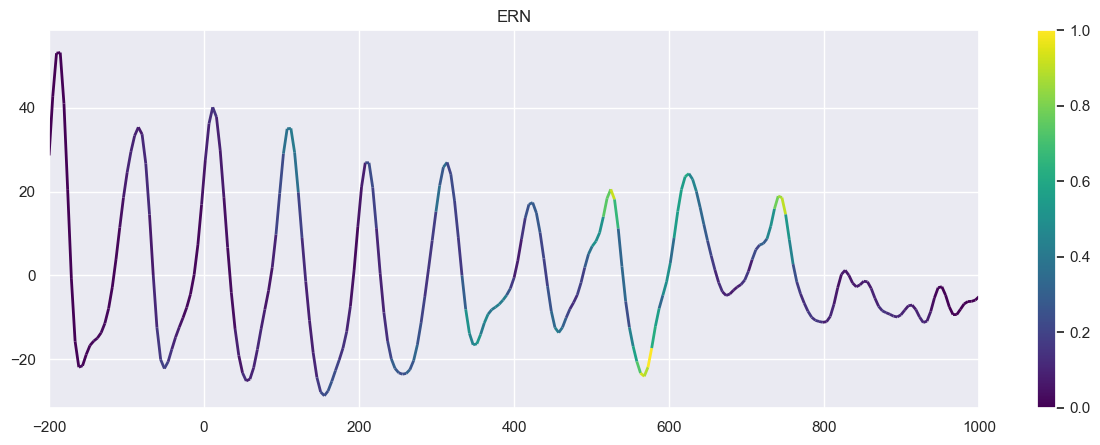

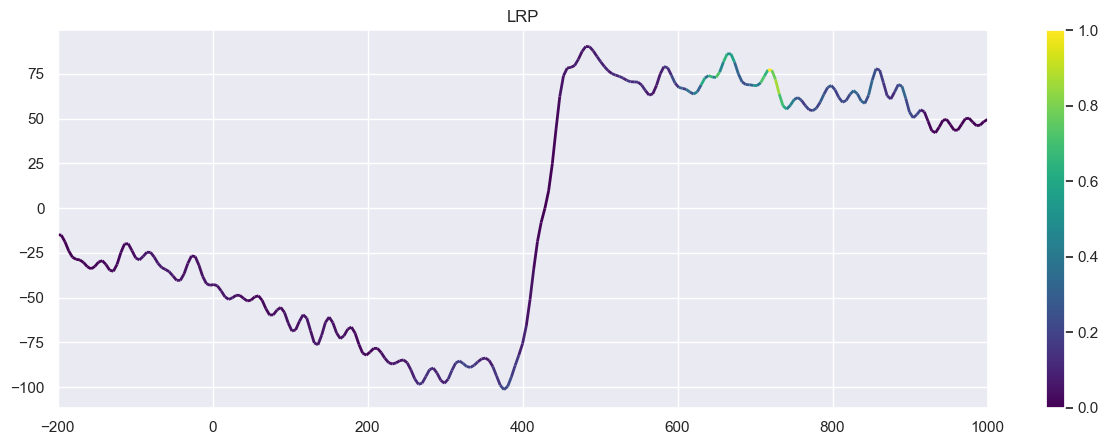

In [8]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"
model_name = "deep"
model_folder = "ModelComparison"

for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    df = df[df["condition"]==1].sample(1)
    data, labels = DataLoader.create_data_labels(df)
    clf, model = Training.init_model(model_name, lr=0.01, gpu=False)
    model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
    clf.load_params(f_params=model_path+"split_"+str(1)+"_model.pkl",
                           f_optimizer=model_path+"split_"+str(1)+"_optimizer.pkl",
                           f_history=model_path+"split_"+str(1)+"_history.json")

    dl = DeepLift(model)
    attribution = 0
    for i in range(len(data)):
        tensor = torch.from_numpy(data[i].reshape(1,28,251)).float()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            attribution += abs(dl.attribute(tensor, target=0))
    plot_attribution_line(data, attribution, task)

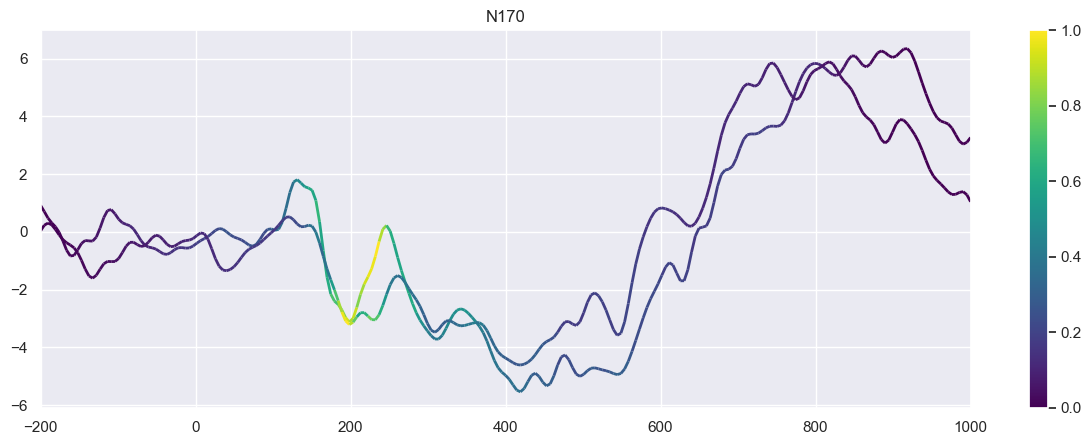

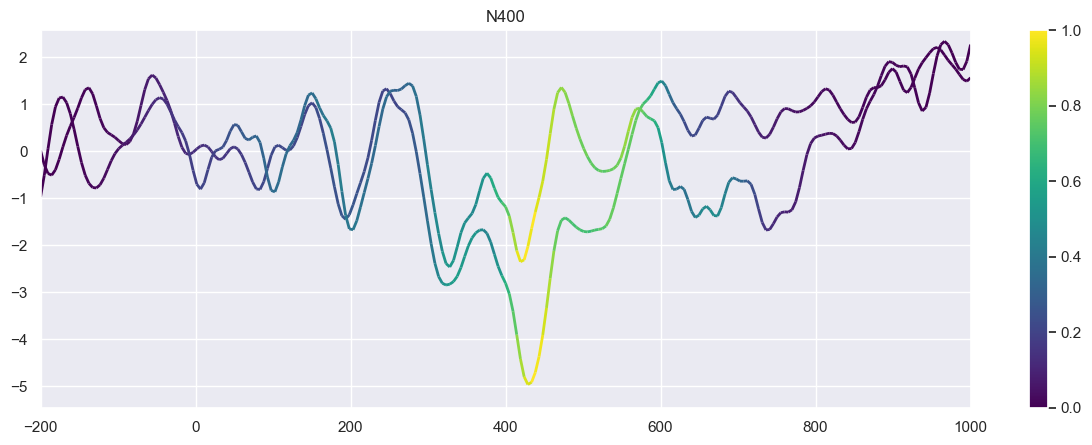

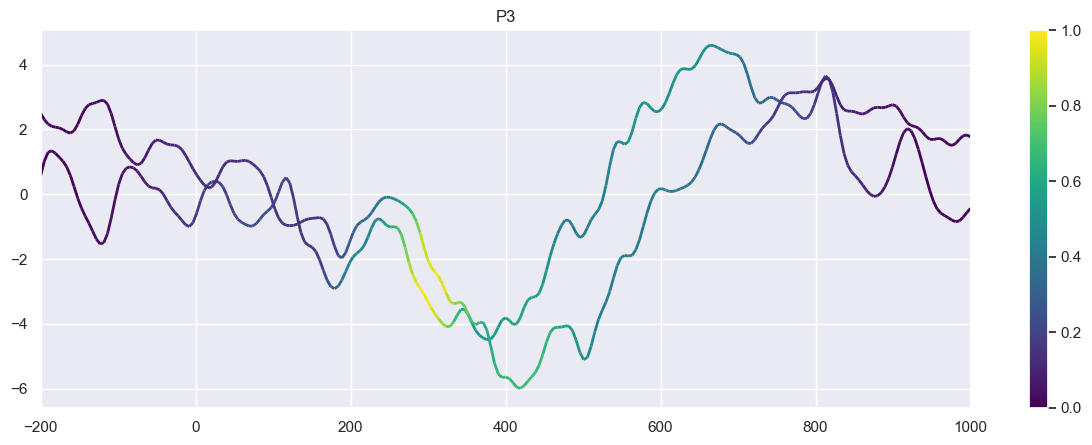

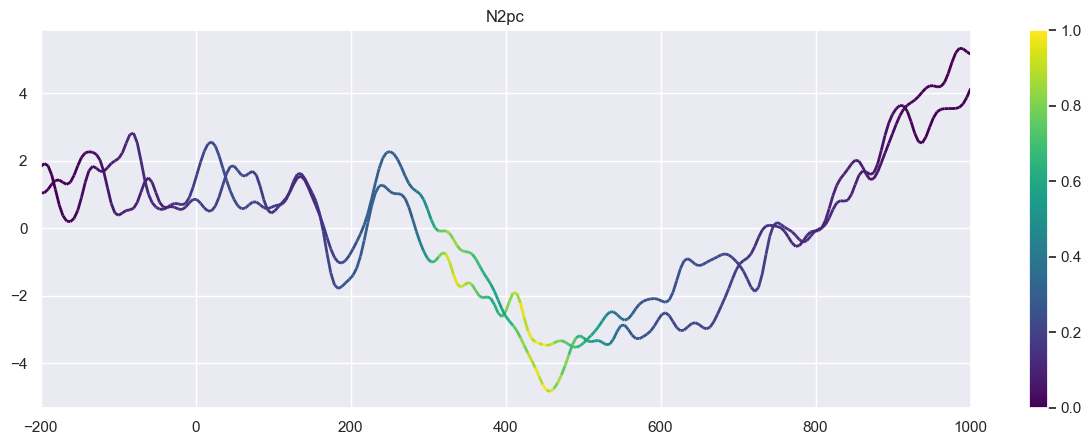

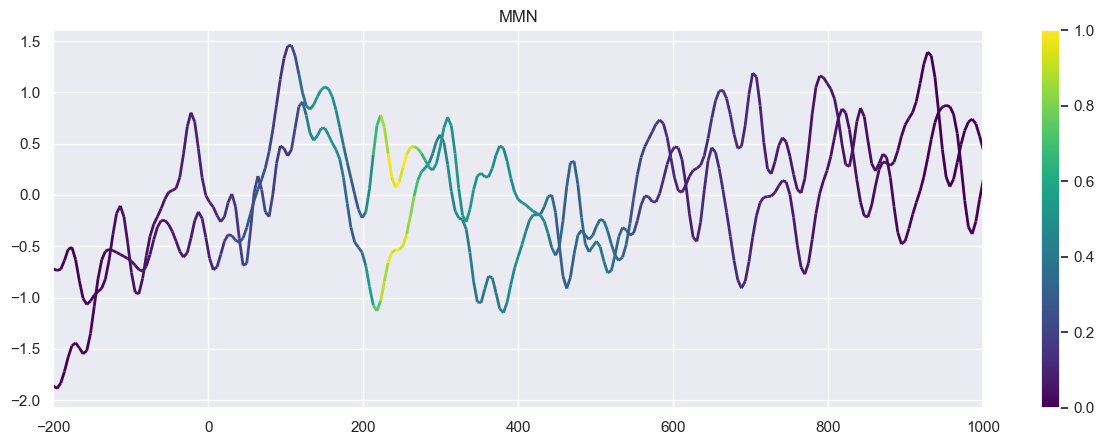

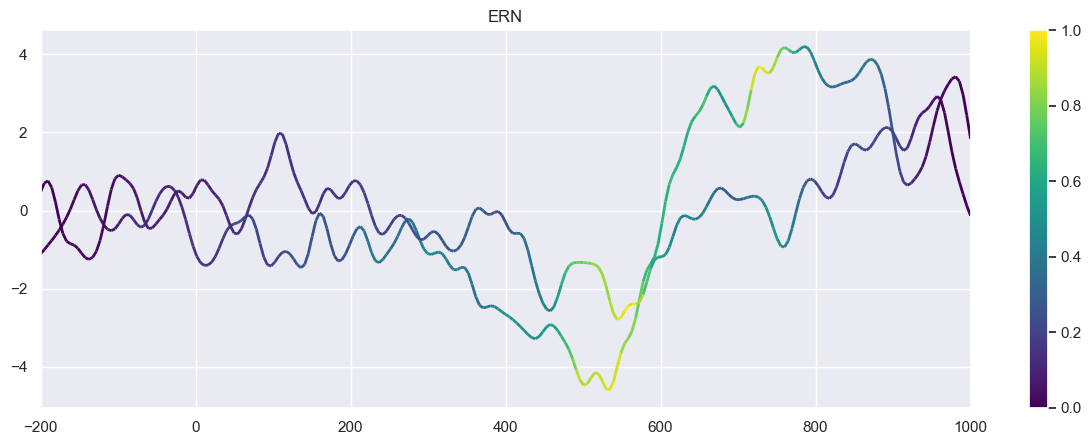

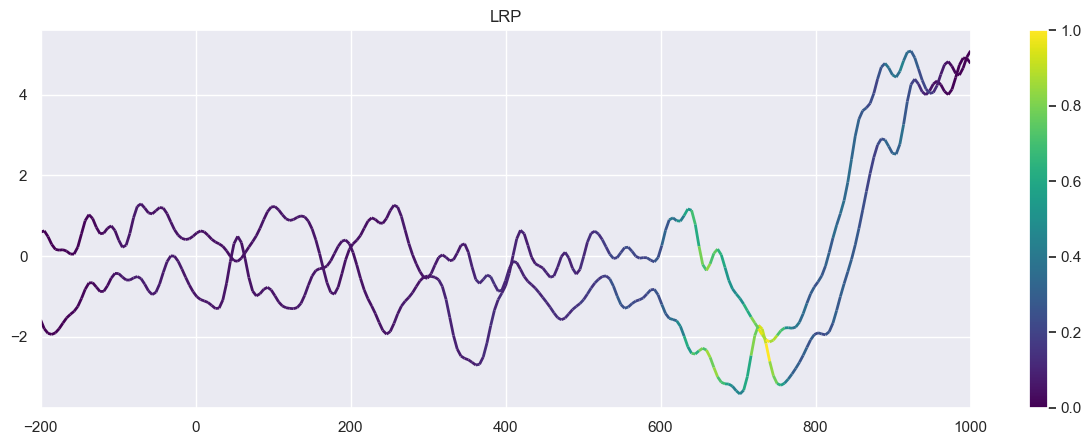

In [9]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"
model_name = "deep"
model_folder = "ModelComparison"

for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    df = df[df["condition"]==0].sample(100)
    data, labels = DataLoader.create_data_labels(df)
    clf, model = Training.init_model(model_name, lr=0.01, gpu=False)
    model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
    clf.load_params(f_params=model_path+"split_"+str(1)+"_model.pkl",
                           f_optimizer=model_path+"split_"+str(1)+"_optimizer.pkl",
                           f_history=model_path+"split_"+str(1)+"_history.json")
    dl = DeepLift(model)
    attribution = 0
    for i in range(len(data)):
        tensor = torch.from_numpy(data[i].reshape(1,28,251)).float()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            attribution += abs(dl.attribute(tensor, target=0))


    df2 = DataLoader.load_df(data_path, task, preprocessing)
    df2 = df2[df2["condition"]==1].sample(100)
    data2, labels2 = DataLoader.create_data_labels(df2)
    clf, model = Training.init_model(model_name, lr=0.01, gpu=False)
    model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
    clf.load_params(f_params=model_path+"split_"+str(1)+"_model.pkl",
                           f_optimizer=model_path+"split_"+str(1)+"_optimizer.pkl",
                           f_history=model_path+"split_"+str(1)+"_history.json")
    dl = DeepLift(model)
    attribution2 = 0
    for i in range(len(data2)):
        tensor = torch.from_numpy(data2[i].reshape(1,28,251)).float()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            attribution2 += abs(dl.attribute(tensor, target=0))
    plot_attribution_lines(data, attribution, data2, attribution2, title=task)

In [10]:
def plot_topo(attribution, task, info):
    sns.reset_orig()
    fig, axes = plt.subplots(1, 10, figsize=(20, 2), dpi=100)
    fig.suptitle(task)
    for i in range(0,10):
        mne.viz.plot_topomap(attribution[:,:,i*25:i*25+25].mean(axis=2).reshape(28,), info,
                             vmin=attribution.numpy().min(),vmax=attribution.numpy().max(),
                             names=info.ch_names, axes=axes[i], show=False)
        if task == "LRP":
            axes[i].set_title(str(i*100-800)+"ms - "+str(i*100-700)+"ms", y=-0.3)
        elif task == "ERN":
            axes[i].set_title(str(i*100-600)+"ms - "+str(i*100-500)+"ms", y=-0.3)
        else:
            axes[i].set_title(str(i*100-200)+"ms - "+str(i*100-100)+"ms", y=-0.3)

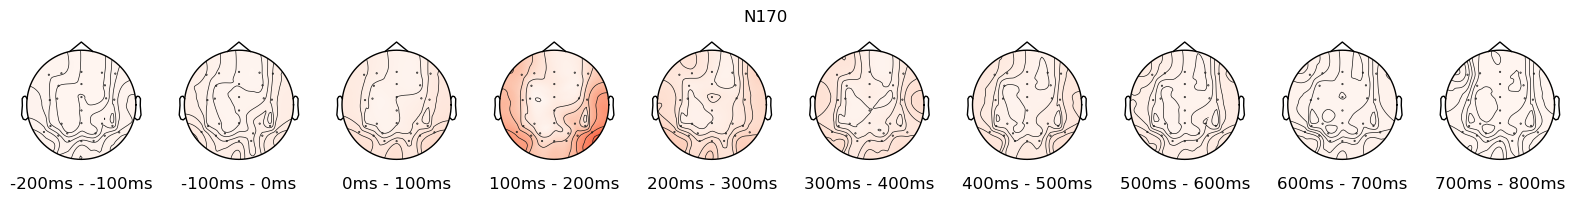

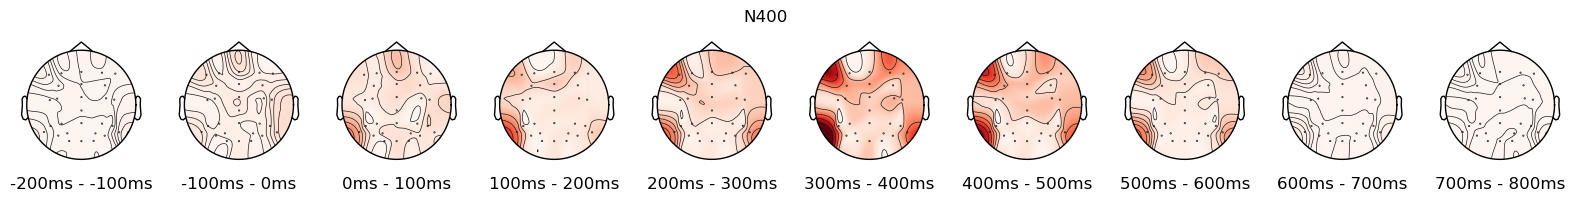

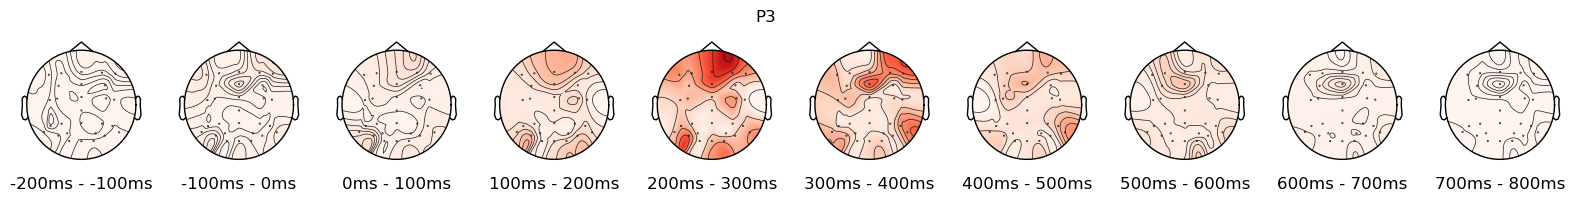

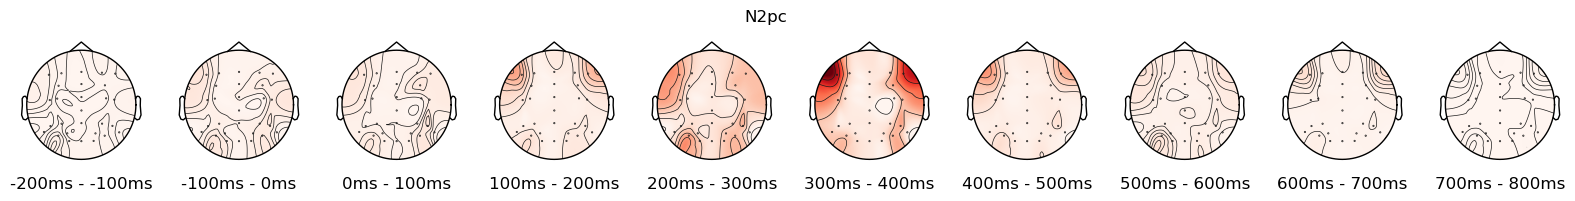

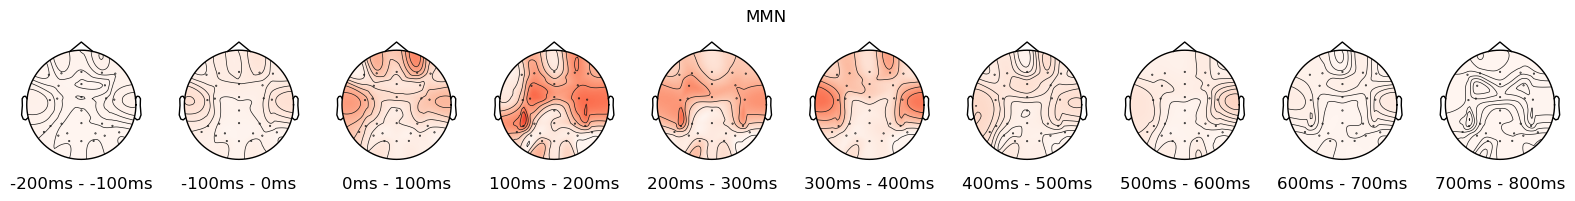

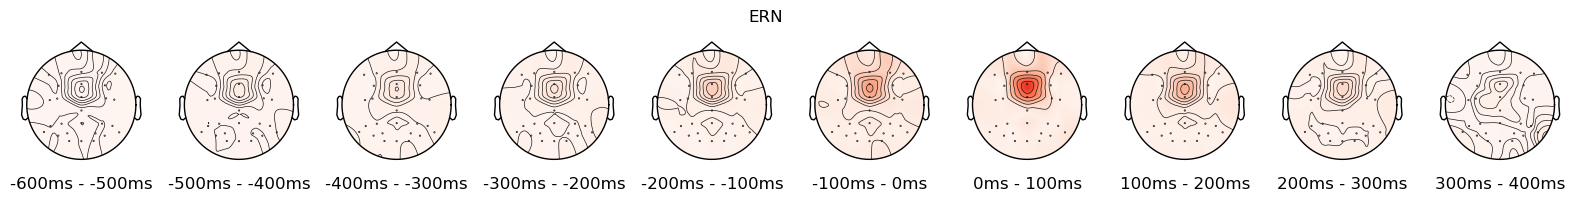

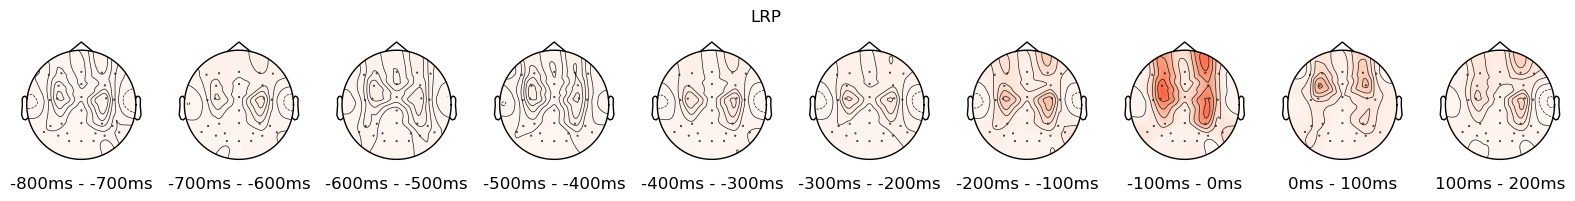

In [11]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"
model_name = "deep"
model_folder = "ModelComparison"

raw = DataLoader.load_raw(data_path, task, preprocessing, "001")
epochs = DataLoader.epoch_raw(raw, task, preprocessing)

for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    df = df[df["condition"]==1].sample(100)
    data, labels = DataLoader.create_data_labels(df)
    clf, model = Training.init_model(model_name, lr=0.01, gpu=False)
    model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
    clf.load_params(f_params=model_path+"split_"+str(1)+"_model.pkl",
                           f_optimizer=model_path+"split_"+str(1)+"_optimizer.pkl",
                           f_history=model_path+"split_"+str(1)+"_history.json")

    dl = DeepLift(model)
    attribution = 0
    for i in range(len(data)):
        tensor = torch.from_numpy(data[i].reshape(1,28,251)).float()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            attribution += abs(dl.attribute(tensor, target=0))
    plot_topo(attribution.detach(), task, epochs.info)

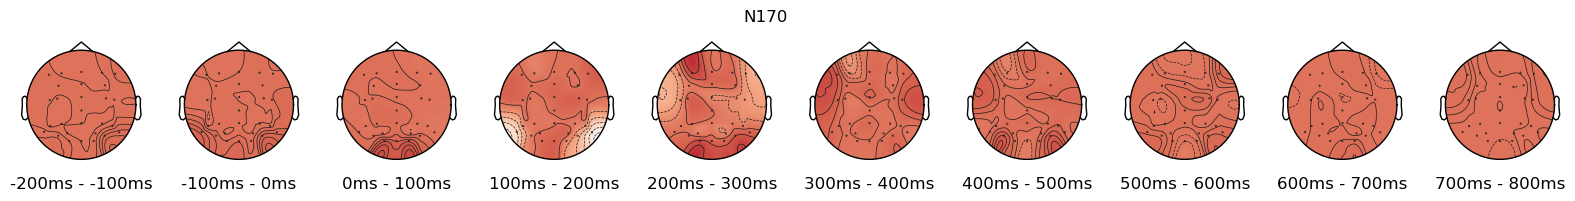

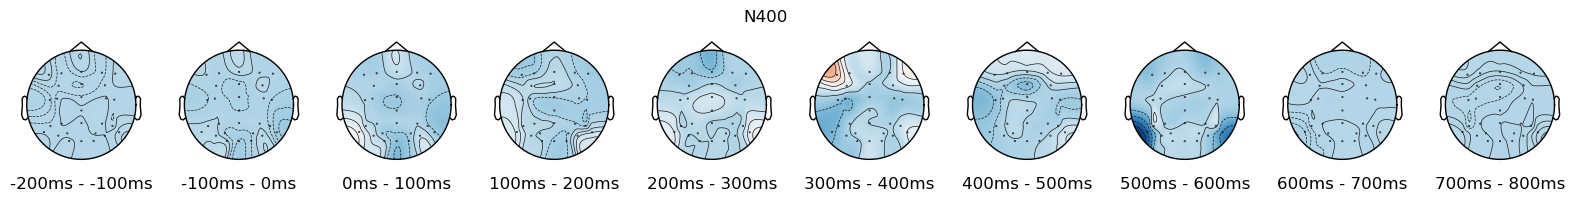

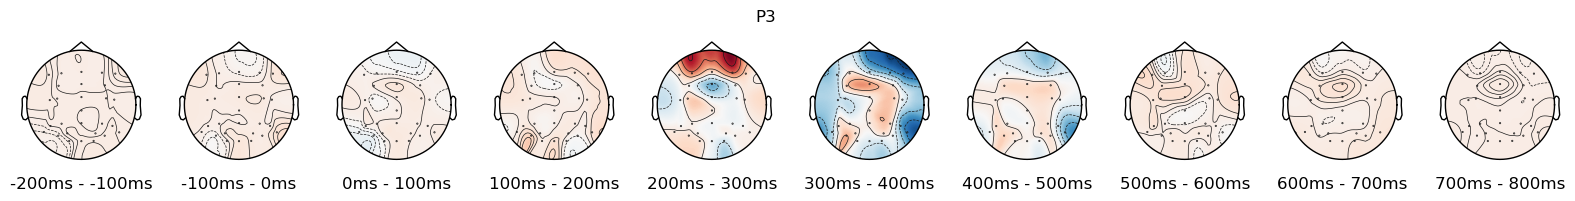

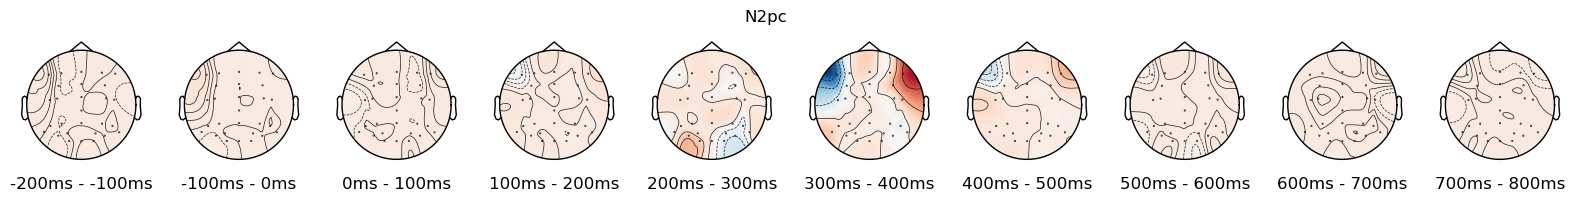

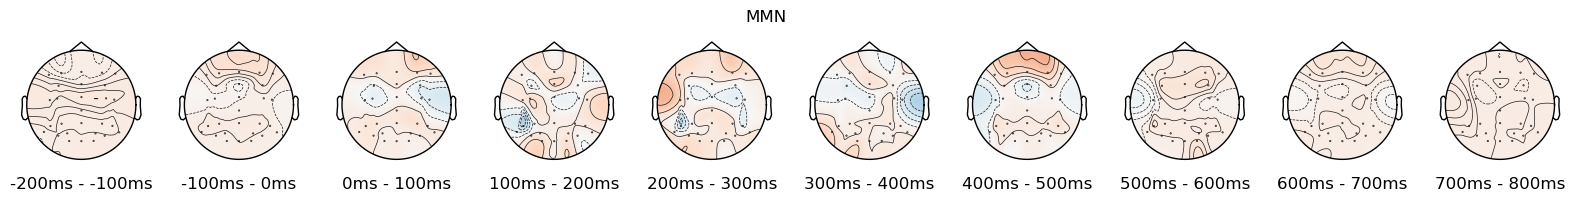

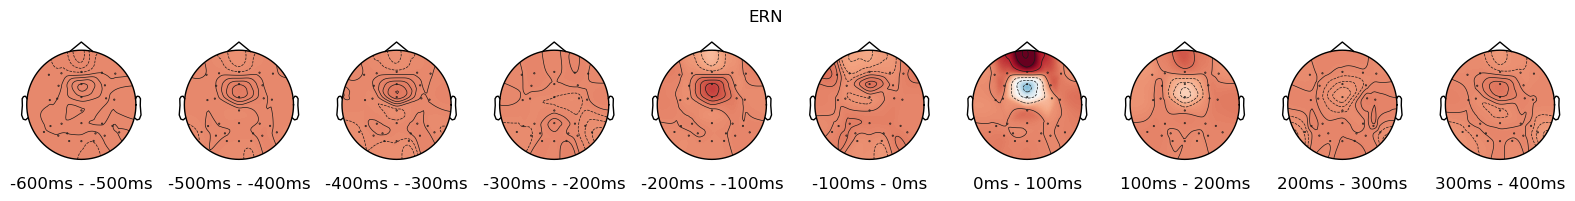

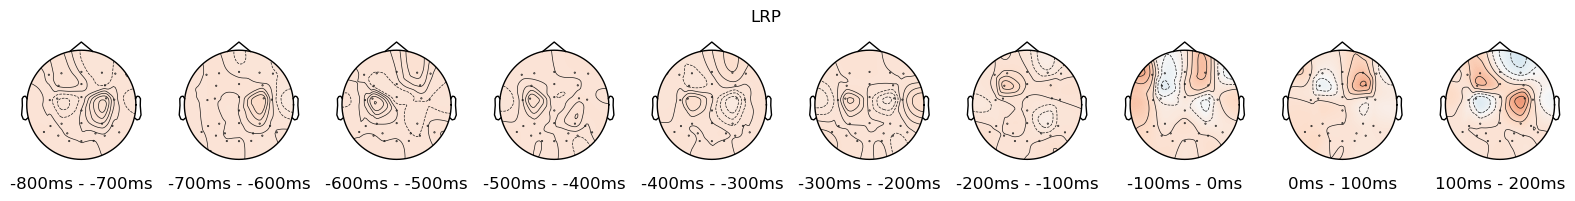

In [12]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"
model_name = "deep"
model_folder = "ModelComparison"

raw = DataLoader.load_raw(data_path, task, preprocessing, "001")
epochs = DataLoader.epoch_raw(raw, task, preprocessing)

for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    df = df[df["condition"]==1].sample(100)
    data, labels = DataLoader.create_data_labels(df)
    clf, model = Training.init_model(model_name, lr=0.01, gpu=False)
    model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
    clf.load_params(f_params=model_path+"split_"+str(1)+"_model.pkl",
                           f_optimizer=model_path+"split_"+str(1)+"_optimizer.pkl",
                           f_history=model_path+"split_"+str(1)+"_history.json")

    dl = DeepLift(model)
    attribution = 0
    for i in range(len(data)):
        tensor = torch.from_numpy(data[i].reshape(1,28,251)).float()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            attribution += (dl.attribute(tensor, target=0))
    plot_topo(attribution.detach(), task, epochs.info)

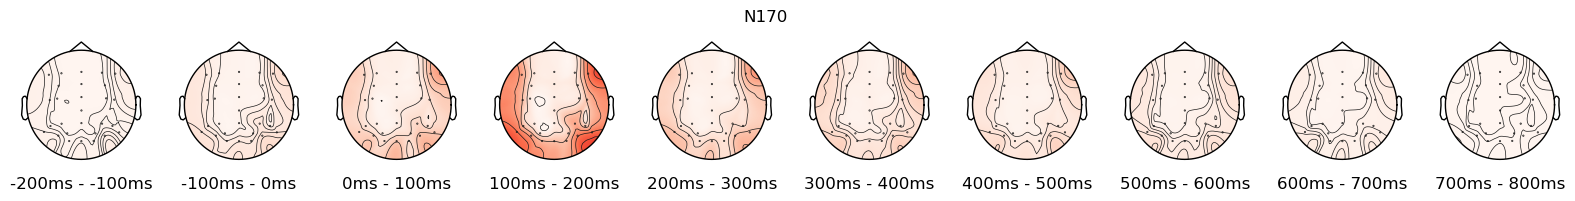

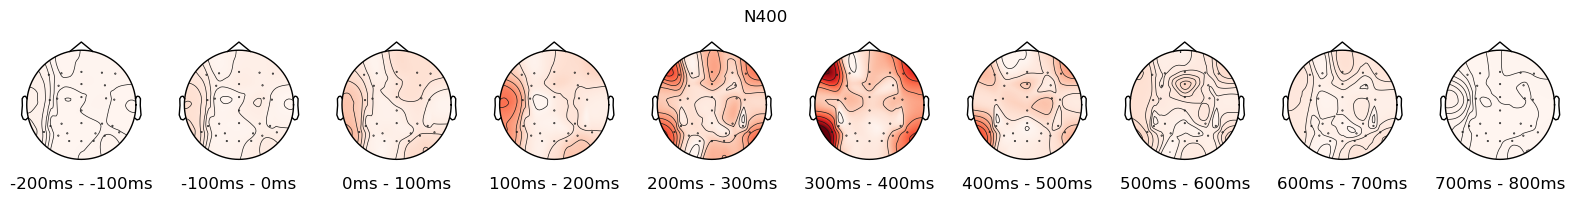

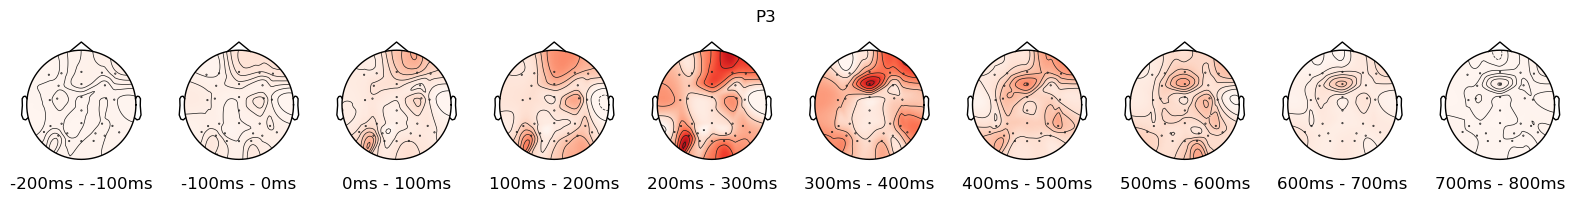

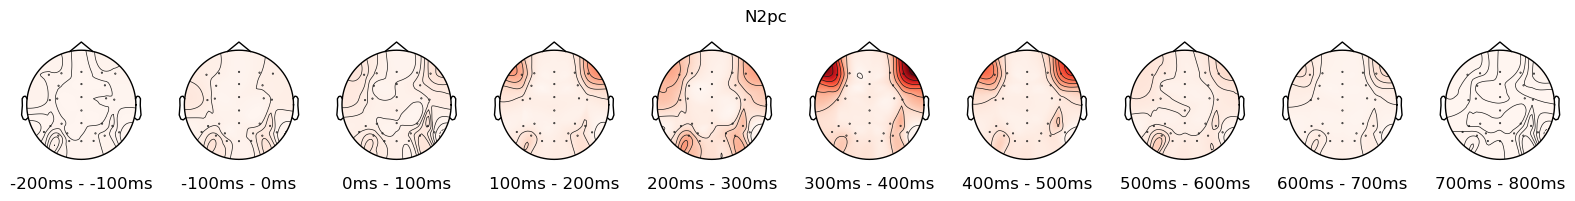

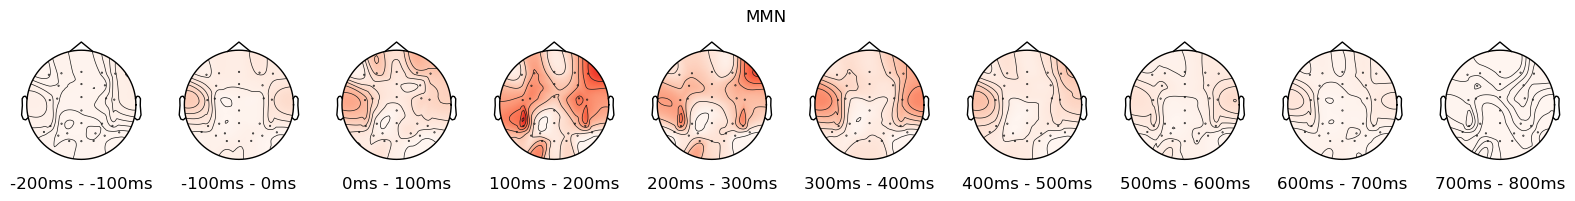

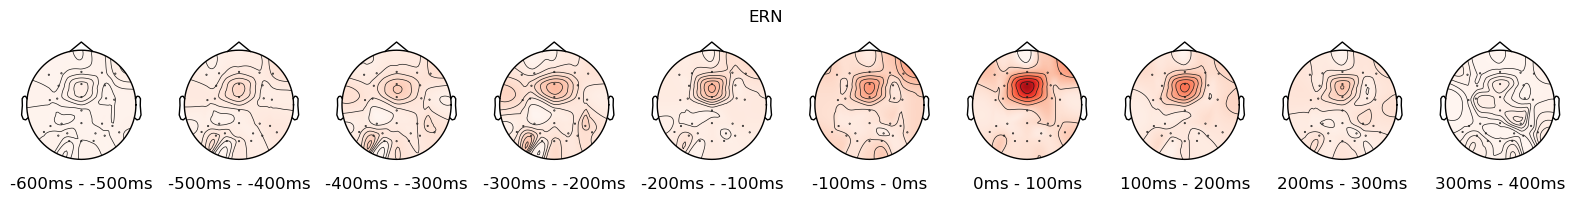

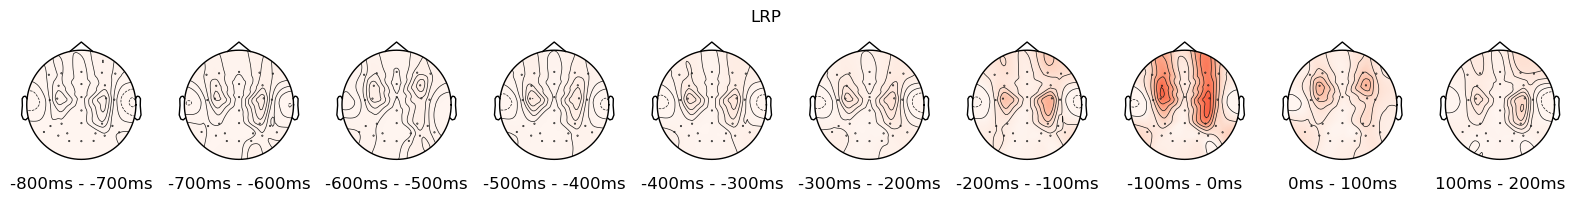

In [13]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"
task = "LRP"
model_name = "deep"
model_folder = "SubjectAnalysis_Unseen"

raw = DataLoader.load_raw(data_path, task, preprocessing, "001")
epochs = DataLoader.epoch_raw(raw, task, preprocessing)
ch_names = ['F3','F7','FC3','C3','C5','P3','P7','P9','PO7','PO3','O1','Oz','Pz','CPz','Fz','F4','F8','FC4','FCz','Cz','C4','C6','P4','P8','P10','PO8','PO4','O2']

for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    data, labels = DataLoader.create_data_labels(df, list_of_subjects=[0])

    clf, model = Training.init_model(model_name, lr=0.01, gpu=False)
    model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
    clf.load_params(f_params=model_path+"split_"+str(0)+"_model.pkl",
                           f_optimizer=model_path+"split_"+str(0)+"_optimizer.pkl",
                           f_history=model_path+"split_"+str(0)+"_history.json")

    fig, axes = plt.subplots(1, 10, figsize=(20, 2), dpi=100)
    fig.suptitle(task)

    dl = captum.attr.DeepLift(model)
    attribution = 0
    for i in range(len(data)):
            tensor = torch.from_numpy(data[i].reshape(1,28,251)).float()
            tensor.requires_grad = True
            #tensor = torch.randn(1, 28, 251, requires_grad=True)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                attribution += abs(dl.attribute(tensor, target=0))
    attribution = attribution.detach()
    for i in range(0,10):
        mne.viz.plot_topomap(attribution[:,:,i*25:i*25+25].mean(axis=2).reshape(28,), epochs.info,
                             vmin=attribution.numpy().min(),vmax=attribution.numpy().max(),
                             names=ch_names, axes=axes[i], show=False)
        if task == "LRP":
            axes[i].set_title(str(i*100-800)+"ms - "+str(i*100-700)+"ms", y=-0.3)
        elif task == "ERN":
            axes[i].set_title(str(i*100-600)+"ms - "+str(i*100-500)+"ms", y=-0.3)
        else:
            axes[i].set_title(str(i*100-200)+"ms - "+str(i*100-100)+"ms", y=-0.3)

In [14]:
# topoplot at point of max attribution
def plot_topo_max(attribution, task, info):
    sns.reset_orig()
    fig, axes = plt.subplots(1, 1, figsize=(2, 2), dpi=100)
    fig.suptitle(task)
    time_max_attr = attribution.detach().numpy().reshape(28,251).mean(axis=0).argmax()
    mne.viz.plot_topomap(attribution[:,:,time_max_attr].reshape(28,), info,
                         vmin=attribution.numpy().min(),vmax=attribution.numpy().max(),
                         names=info.ch_names, axes=axes, show=False)
    if task == "LRP":
        axes.set_title(str(time_max_attr*4-800)+"ms", y=-0.3)
    elif task == "ERN":
        axes.set_title(str(time_max_attr*4-600)+"ms", y=-0.3)
    else:
        axes.set_title(str(time_max_attr*4-200)+"ms", y=-0.3)

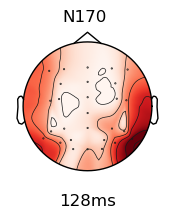

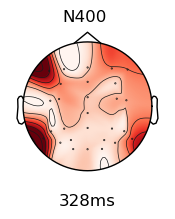

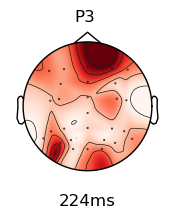

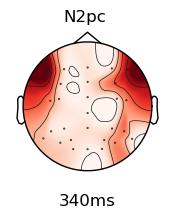

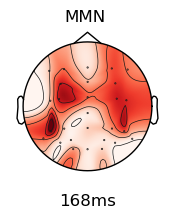

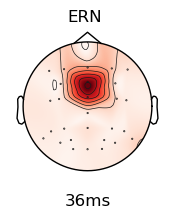

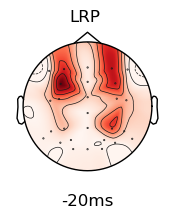

In [15]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"
model_name = "deep"
model_folder = "ModelComparison"

raw = DataLoader.load_raw(data_path, task, preprocessing, "001")
epochs = DataLoader.epoch_raw(raw, task, preprocessing)

for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    df = df[df["condition"]==1].sample(100)
    data, labels = DataLoader.create_data_labels(df)
    clf, model = Training.init_model(model_name, lr=0.01, gpu=False)
    model_path = os.getcwd()+"\\"+model_folder+"\\"+model_name+"\\"+task+"\\"+preprocessing+"\\"
    clf.load_params(f_params=model_path+"split_"+str(1)+"_model.pkl",
                           f_optimizer=model_path+"split_"+str(1)+"_optimizer.pkl",
                           f_history=model_path+"split_"+str(1)+"_history.json")

    dl = DeepLift(model)
    attribution = 0
    for i in range(len(data)):
        tensor = torch.from_numpy(data[i].reshape(1,28,251)).float()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            attribution += abs(dl.attribute(tensor, target=0))
    plot_topo_max(attribution.detach(), task, epochs.info)